<a href="https://colab.research.google.com/github/utility001/cifar-10/blob/main/cifar_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

+ Use a pretrained model -- MobileNetV2

## Imports

In [1]:
# # !pip install --upgrade tf-keras
# !pip install tensorflow==2.16.1
# !pip install tensorflow_datasets
# !pip install keras-tuner
# !pip install scikit-learn==1.4.2
# !pip install gradio

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

2024-05-21 12:40:48.645439: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:40:50.673943: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:40:58.327956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 12:41:07.435334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


## Ingest

In [4]:
# cifar_10 details
tf.keras.datasets.cifar10.load_data?

Signature: tf.keras.datasets.cifar10.load_data()
Docstring:
Loads the CIFAR10 dataset.

This is a dataset of 50,000 32x32 color training images and 10,000 test
images, labeled over 10 categories. See more info at the
[CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html).

The classes are:

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

**`x_train`**: `uint8` NumPy array of grayscale image data with shapes
  `(50000, 32, 32, 3)`, containing the training data. Pixel values range
  from 0 to 255.

**`y_train`**: `uint8` NumPy array of labels (integers in range 0-9)
  with shape `(50000, 1)` for the training data.

**`x_test`**: `uint8` NumPy array of grayscale image d

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    random_state=42,
    test_size=10_000,
    shuffle=True,
    stratify=y_train_full
)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
y_train.shape, y_val.shape, y_test.shape

((40000, 1), (10000, 1), (10000, 1))

In [10]:
X_train[0].shape

(32, 32, 3)

In [11]:
X_train[0].min(), X_train[0].max()

(0, 217)

In [12]:
X_train.min(), X_train.max()

(0, 255)

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
class_names[y_train.flatten()[0]]

'frog'

In [15]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
y_test[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=uint8)

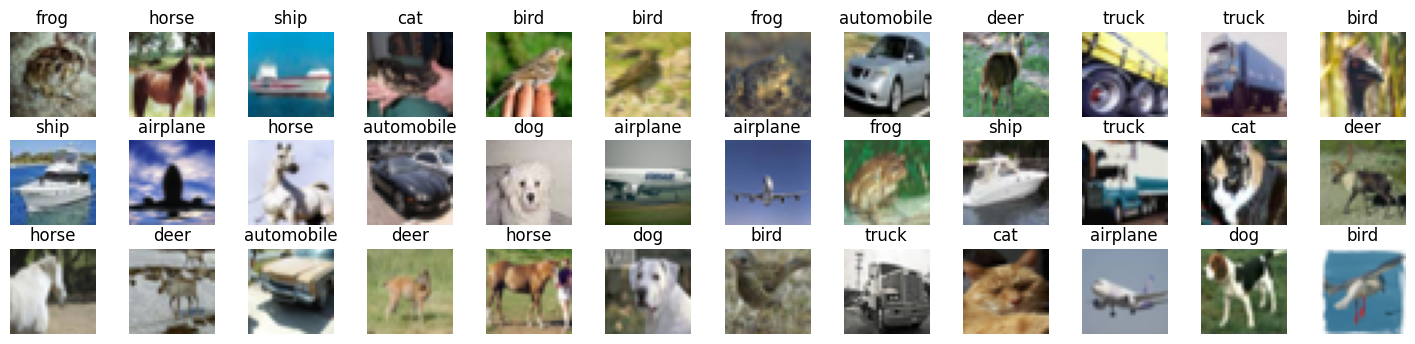

In [16]:
#  Plot a few images from the dataset
plt.figure(figsize=(18, 4))
for idx, image_data in enumerate(X_train[:36]):
    plt.subplot(3, 12, idx + 1)
    plt.imshow(X_train[idx], cmap="binary")
    plt.axis("off");
    plt.title(class_names[y_train[idx]])
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show();

In [17]:
def label_stats(y_train, y_val, y_test):
    # Convert numpy arrays to pandas Series
    y_train_series = pd.Series(y_train)
    y_val_series = pd.Series(y_val)
    y_test_series = pd.Series(y_test)

    # Calculate value counts and percentages for each set
    train_counts = y_train_series.value_counts()
    val_counts = y_val_series.value_counts()
    test_counts = y_test_series.value_counts()

    train_percentages = train_counts / len(y_train_series) * 100
    val_percentages = val_counts / len(y_val_series) * 100
    test_percentages = test_counts / len(y_test_series) * 100

    # Combine counts and percentages into a single DataFrame
    stats_df = pd.DataFrame({
        'Train Counts': train_counts,
        'Train Percentages': train_percentages,
        'Valid Counts': val_counts,
        'Valid Percentages': val_percentages,
        'Test Counts': test_counts,
        'Test Percentages': test_percentages
    })

    # Fill NaN values with 0 (if a label is not present in one of the sets)
    stats_df = stats_df.fillna(0)

    return stats_df

In [18]:
label_stats(y_train, y_val, y_test)

,Train Counts,Train Percentages,Valid Counts,Valid Percentages,Test Counts,Test Percentages
0,4000,10.0,1000,10.0,1000,10.0
1,4000,10.0,1000,10.0,1000,10.0
2,4000,10.0,1000,10.0,1000,10.0
3,4000,10.0,1000,10.0,1000,10.0
4,4000,10.0,1000,10.0,1000,10.0
5,4000,10.0,1000,10.0,1000,10.0
6,4000,10.0,1000,10.0,1000,10.0
7,4000,10.0,1000,10.0,1000,10.0
8,4000,10.0,1000,10.0,1000,10.0
9,4000,10.0,1000,10.0,1000,10.0


## MobileNetV2

+ Load and inspect the pretrained model

In [19]:
# Load MobileNetV2
mnv2 = tf.keras.applications.MobileNetV2(weights="imagenet")

In [20]:
len(mnv2.layers)

156

In [21]:
mnv2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [22]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     mnv2,
#     to_file="model_plots/MobileNetV2_architecture.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     dpi=60)

## Prepare the data for the task

+ Resizing the images crashed my system. So Convert it into tf.data.datasets format
+ MobileNetV2 demands the image to be [96, 128, 160, 192, 224], resize the input images
+ Apply MobileNetV2 processing steps

In [23]:
# convert to tf.data.datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="cifar_10_train")
val_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val), name="cifar_10_val")
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="cifar_10_test")

2024-05-21 12:41:30.086371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


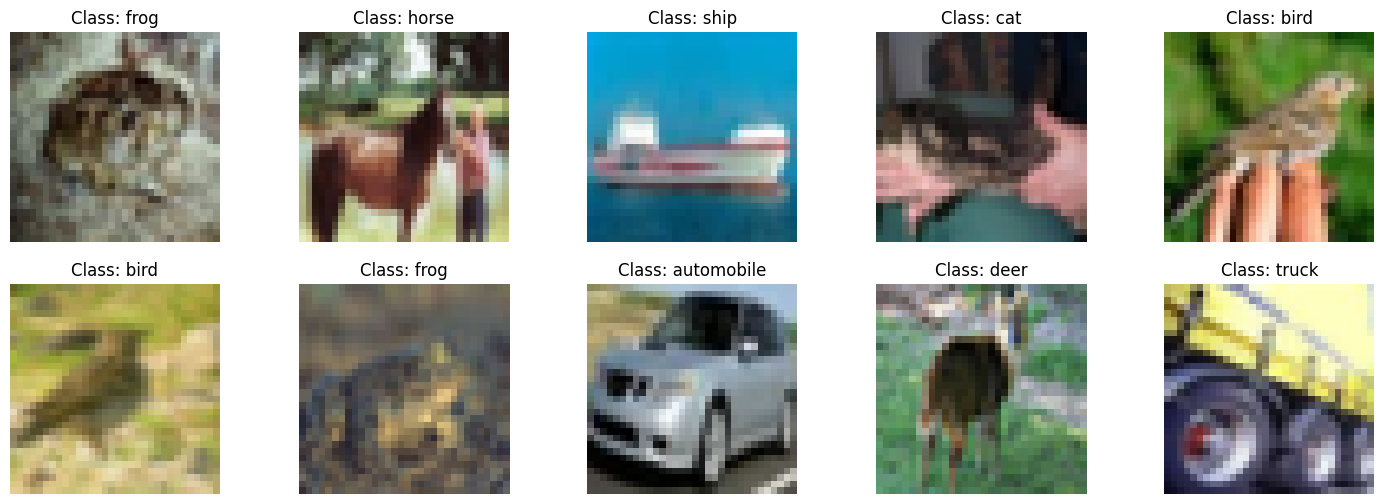

In [24]:
# Some images in the train set

plt.figure(figsize=(18, 6))
index=0
for image, label in train_set_raw.take(10):
  index += 1
  plt.subplot(2, 5, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")
plt.show()

In [25]:
tf.keras.backend.clear_session()

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=False),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)
])

In [26]:
batch_size = 32
train_set = (train_set_raw
             .map(lambda X, y: (preprocess(X), y))
             .shuffle(1000, seed=42)
             .batch(batch_size)
             .prefetch(tf.data.AUTOTUNE)
            )

In [27]:
# preprocess the validation set
val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

2024-05-21 12:41:32.096776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


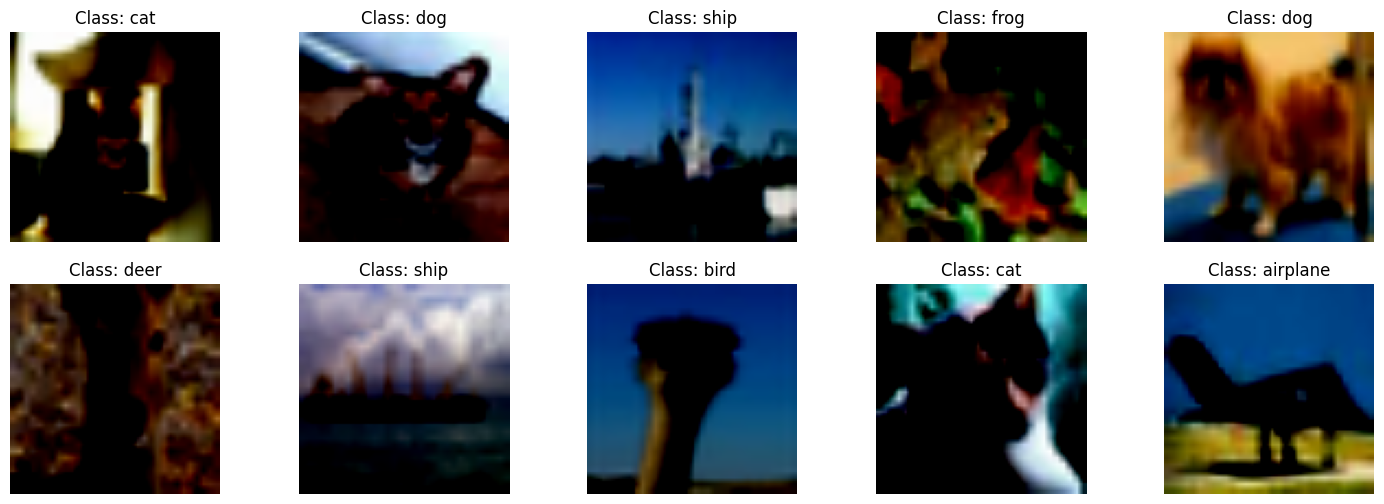

In [28]:
# View the images after resizing and batching

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  index += 1
  plt.subplot(2, 5, index)
  # print(f"max: {np.max(X_batch[index])}. min: {np.min(X_batch[index])}")
  plt.imshow(np.clip(X_batch[index], 0, 1))
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

In [29]:
# Retrieve the first element from the dataset
for image, label in train_set.take(1):
    first_image_size = tf.shape(image[0]).numpy()
    print("First image size:", first_image_size)

First image size: [96 96  3]


2024-05-21 12:41:32.929688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
_input_shape = list(first_image_size)
_input_shape

[96, 96, 3]

## Setup the base model and add your outputs

In [31]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=_input_shape,
    include_top=False
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Which layers were removed??
base_model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [33]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     base_model,
#     to_file="model_plots/MobileNetV2_base.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     show_trainable=True,
#     dpi=60)

In [34]:
len(base_model.layers)

154

The last two layers

In [35]:
n_classes = len(class_names)
n_classes

10

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


avg = tf.keras.layers.GlobalAveragePooling2D(keepdims=False)(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [37]:
# # View
# tf.keras.utils.plot_model(
#     model,
#     to_file="MobileNetV2_w_added.png",
#     # to_file="model_plots/MobileNetV2_w_added.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     show_trainable=True,
#     dpi=60)

In [38]:
# Freeze all of the weights of the pretrained layers
base_model.trainable = False

In [39]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Warm the model up

Task
+ Train teh model for a few epochs while keeping the base model weights fixed
+ This is in order to warm up the weights and biases in the top layers
+ Use a common learning rate rather than performing hyperparameter tuning
  Tuning lr is not to important in the first training as it might have limited impact since the base layers are frozen and the top layers are too few compared to the rest of the model
+ Monitor the validation accuracy ----- Stalling model or overfitting. decrease learning rate. Underfitting. increase slightly

In [40]:
ecb = tf.keras.callbacks.EarlyStopping(patience=5)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [42]:
history = model.fit(train_set, validation_data=val_set, epochs=15, callbacks=[ecb])

Epoch 1/15


I0000 00:00:1716287528.423970     153 service.cc:145] XLA service 0x7b5758006350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716287528.424021     153 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1716287528.424027     153 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  19/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2300 - loss: 38.2723

I0000 00:00:1716287533.353673     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7368 - loss: 11.8182 - val_accuracy: 0.7744 - val_loss: 16.8125
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8188 - loss: 11.8087 - val_accuracy: 0.8263 - val_loss: 12.7868
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8296 - loss: 12.5401 - val_accuracy: 0.7953 - val_loss: 20.6620
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8436 - loss: 11.6839 - val_accuracy: 0.8134 - val_loss: 16.5865
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8478 - loss: 11.8346 - val_accuracy: 0.8307 - val_loss: 15.6025
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8519 - loss: 11.7246 - val_accuracy: 0.8279 - val_loss: 17.2638
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8558 - loss: 11.6977 - val_accuracy: 0.8330 - val_loss: 17.5505


Now the top layers are not too bad.  
+ Let's make the top part of the base mode trainable again.
+ Tune the learning rate
+ Utilize learning rate scheduling

In [43]:
for layer in base_model.layers[-11:]:
    layer.trainable = True

In [44]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Hyperparameter tuning

Tune learning schedule hyperparameters

### Tune learning rate

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
#     lr = hp.Choice("learning_rate", values=[0.3, 0.1, 0.01, 0.003, 0.001, 0.003, 0.0001]) 
# --first try 0.0001 was the best (0.87) but it was teh lowest hyperparameter choice so i decided to go lower to see whether we can do better
    lr = hp.Choice("learning_rate", values=[0.0001, 0.0003, 0.00001])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9, beta_2=0.999
    )

    model_clone = tf.keras.models.clone_model(model)
    model_clone.set_weights(model.get_weights())

    model_clone.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer, metrics=["accuracy"])

    return model_clone

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=7, overwrite=True,
    directory="kt_parameter_tuning", project_name="random_search", seed=42)

In [ ]:
random_search_tuner.search(train_set, epochs=10,
                           validation_data=val_set)

In [ ]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

In [ ]:
for model in best_trials:
  print(model.summary())

### Tune Performance scheduling parameters

In [46]:
import keras_tuner as kt

In [47]:
tf.keras.backend.clear_session()
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model_clone = tf.keras.models.clone_model(model)
        model_clone.set_weights(model.get_weights())
        
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001,  # The learning rate gotten from previous hyperparameter tuning
            beta_1=0.9, beta_2=0.999
        )

        model_clone.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"]
        )
        
        return model_clone

    def fit(self, hp, model, *args, **kwargs):
        factor = hp.Float('factor', min_value=0.1, max_value=0.9, step=0.1)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=factor,
            patience=2,
            min_lr=1e-6
        )
        
        # Extract callbacks from kwargs if they exist
        callbacks = kwargs.pop('callbacks', [])
        callbacks.append(reduce_lr)
                
        return model.fit(
            *args,
            callbacks=callbacks,
            **kwargs,
        )

In [48]:
random_search_tuner = kt.RandomSearch(
    MyHyperModel(), objective="val_accuracy", max_trials=10, overwrite=True,
    directory="kt_performance_tuning", project_name="random_performance_search", seed=42)

In [49]:
ecb = tf.keras.callbacks.EarlyStopping(patience=10)

In [50]:
random_search_tuner.search(train_set, epochs=15,
                           validation_data=val_set, callbacks=[ecb])

Trial 9 Complete [00h 04m 14s]
val_accuracy: 0.882099986076355

Best val_accuracy So Far: 0.8831999897956848
Total elapsed time: 00h 36m 51s


In [60]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=10)

In [61]:
for model in best_trials:
    model.summary()

Trial 04 summary
Hyperparameters:
factor: 0.8
Score: 0.8831999897956848
Trial 05 summary
Hyperparameters:
factor: 0.5
Score: 0.8828999996185303
Trial 03 summary
Hyperparameters:
factor: 0.30000000000000004
Score: 0.882099986076355
Trial 08 summary
Hyperparameters:
factor: 0.2
Score: 0.882099986076355
Trial 00 summary
Hyperparameters:
factor: 0.1
Score: 0.8816999793052673
Trial 07 summary
Hyperparameters:
factor: 0.7000000000000001
Score: 0.8809999823570251
Trial 02 summary
Hyperparameters:
factor: 0.4
Score: 0.8798999786376953
Trial 01 summary
Hyperparameters:
factor: 0.6
Score: 0.8781999945640564
Trial 06 summary
Hyperparameters:
factor: 0.9
Score: 0.8781999945640564


## Training

In [46]:
tf.keras.backend.clear_session()

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=2)
ecb = tf.keras.callbacks.EarlyStopping(patience=10)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer, metrics=["accuracy"])

In [48]:
history = model.fit(train_set, validation_data=val_set, callbacks=[ecb, lr_scheduler], epochs=100)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7659 - loss: 36.2783 - val_accuracy: 0.8218 - val_loss: 5.8200 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8485 - loss: 1.1918 - val_accuracy: 0.8318 - val_loss: 1.9644 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8649 - loss: 0.7164 - val_accuracy: 0.8090 - val_loss: 1.7967 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8750 - loss: 0.5264 - val_accuracy: 0.7977 - val_loss: 2.1348 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8803 - loss: 0.4642 - val_accuracy: 0.5191 - val_loss: 13.3245 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8922 - loss: 0.3774 - val_accuracy: 0.8185 - val_loss: 1.4571 - learning_rate: 8.0000e-04
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/

In [49]:
print(3)

3


In [50]:
model.save("cifar_tl_model.keras")

# Evaluation

In [31]:
# saved_model = tf.keras.models.load_model("saved_models/cifar_tl_model.keras")
saved_model = tf.keras.models.load_model("saved_models/cifar_tl_model.keras")

In [ ]:
# batch_size = 12

In [ ]:
tloss, tacc = saved_model.evaluate(train_set)

In [53]:
tloss, tacc

(0.001204231521114707, 0.999625027179718)

In [54]:
vloss, vacc = saved_model.evaluate(val_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8987 - loss: 0.6977


In [55]:
vloss, vacc

(0.7577487230300903, 0.8956000208854675)

In [56]:
true_class_names = []
predicted_class_names = []

# Get the  predictions and their original class_names
for image, label in val_set:
    # Get pred probas
    pred= saved_model.predict(image)
    # convert them to actual classes
    predicted_class_names.extend(pred.argmax(axis=1))
    # get the true label
    true_class_names.extend(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [57]:
np_true_class_names = np.array(true_class_names)
np_true_class_names[:10]

array([2, 7, 1, 9, 6, 8, 8, 2, 2, 7], dtype=uint8)

In [58]:
np_predicted_class_names = np.array(predicted_class_names)
np_predicted_class_names[:10]

array([2, 7, 1, 9, 6, 0, 8, 2, 2, 7])

In [59]:
misclassified = np.flatnonzero(np_true_class_names != np_predicted_class_names)
# how many
print(len(misclassified))
# View 10
misclassified[:10]

1044


array([ 5, 16, 20, 23, 41, 45, 49, 51, 56, 58])

In [60]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

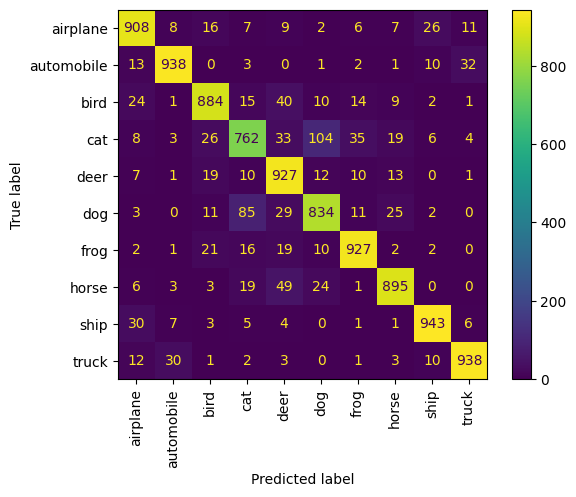

In [66]:
ConfusionMatrixDisplay.from_predictions(
    y_true = np_true_class_names,
    y_pred = np_predicted_class_names,
    display_labels=class_names,
    xticks_rotation="vertical"
);

This is expected. The pictures are quite pixelated

# Error analysis with gradio

In [64]:
from PIL import Image

image_path = "sample_images/images.jpeg"
image = Image.open(image_path)

# Convert  to np array
image_array = np.array(image)

image_array.shape

(168, 299, 3)

In [66]:
# convert the image to a numpy array
image = np.array(image_array)

# Add an axis. To represent batch size. Models are trained with an extra axis at the front to represent batch size
image = image[np.newaxis, ...]

# resize the image
resize = tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=False)
res_img = resize(image)

# preprocess the image
prep_img = tf.keras.applications.mobilenet_v2.preprocess_input(res_img)

# pred_probas
pred_probas = saved_model.predict(prep_img)

# Get the top 3 predictions
top_3_indices = np.argsort(pred_probas[0])[-3:][::-1]
top_3_labels = [class_names[i] for i in top_3_indices]
top_3_probas = ["{:.5f}".format(pred_probas[0][i]) for i in top_3_indices]
# top_3_probas = [pred_probas[0][i].to for i in top_3_indices]

# Format the result
results = {label: prob for label, prob in zip(top_3_labels, top_3_probas)}
# results = [(label, prob) for label, prob in zip(top_3_labels, top_3_probas)]

print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
{'airplane': '1.00000', 'bird': '0.00000', 'truck': '0.00000'}


In [ ]:
# pred_probas
pred_probas = saved_model.predict(prep_img)
# Get the value of the max predicion probability
max_pred_proba = np.max(pred_probas)
# get the ineex of the max prediction probability
pred = np.argmax(pred_probas, axis=1)
# label
label = class_names[pred[0]]

# Predictions with Gradio

In [67]:
def image_pred(image, crop_to_aspect_ratio=True):
    # convert the image to a numpy array
    image = np.array(image)

    # Add an axis. To represent batch size. Models are trained with an extra axis at the front to represent batch size
    image = image[np.newaxis, ...]

    # resize the image
    resize = tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=False)
    res_img = resize(image)

    # preprocess the image
    prep_img = tf.keras.applications.mobilenet_v2.preprocess_input(res_img)

    # pred_probas
    pred_probas = saved_model.predict(prep_img)

    # Get the top 3 predictions
    top_3_indices = np.argsort(pred_probas[0])[-3:][::-1]
    top_3_labels = [class_names[i] for i in top_3_indices]
    top_3_probas = ["{:.5f}".format(pred_probas[0][i]) for i in top_3_indices]
    # top_3_probas = [pred_probas[0][i].to for i in top_3_indices]
    
    # Format the result
    results = {label: prob for label, prob in zip(top_3_labels, top_3_probas)}

    # Convert the transformed image to an array
    res_array = np.array(res_img)
    # remove the first axis that was added above
    squeeze = np.squeeze(res_array, axis=0)
    # divide by max value
    plot_image = squeeze/250
    # clip
    clip = np.clip(plot_image, 0, 1)

    return clip, results

In [68]:
from PIL import Image

image_path = "sample_images/images.jpeg"
image = Image.open(image_path)

# Convert  to np array
image_array = np.array(image)

image_array.shape

(168, 299, 3)

In [69]:
t, u = image_pred(image_array)
u

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


{'airplane': '1.00000', 'bird': '0.00000', 'truck': '0.00000'}

In [70]:
import gradio as gr

In [ ]:
# Define a new prediction function for Gradio
def predict_with_top_3_labels(image):
    results = predict_top_3_labels(image)
    # Format the results as a string with each label and probability on a new line
    result_str = "\n".join([f"Label: {label}, Probability: {prob}" for label, prob in results.items()])
    return result_str

# List of example images (nested list format)
examples = [
    ["path_to_sample_image1.jpg"],
    ["path_to_sample_image2.jpg"],
    ["path_to_sample_image3.jpg"]
]


In [71]:
example_images = [
    ["sample_images/automobile.jpg"],
    ["sample_images/frog.jpg"],
    ["sample_images/deer.jpg"],
    ["sample_images/ct.jpeg"],
    ["sample_images/images.jpeg"],
    ["sample_images/trk.jpeg"],
    ["sample_images/ship.jpeg"],
    ["sample_images/bd.jpeg"],
    ["sample_images/dg.jpeg"],
    ["sample_images/hs.webp"]
]

In [72]:
# Create the Gradio interface
interface = gr.Interface(
    fn=image_pred,
    examples = example_images,
    inputs=[
        gr.Image(value="Image", type="numpy"),
        gr.Checkbox(label="Crop to aspect ratio")
    ],
    outputs=[
        gr.Image(value="Image", type="numpy", height=100, width=100),
        gr.Text(label="Prediction"),
    ],
    title="MobileNet 50 pretrained model. Trained on cifar-10 dataset",
    description="""
    The class names are 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    """
)

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.28.3, however version 4.29.0 is available, please upgrade.
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
